      delta  czz_diag  cxx_diag
0  0.300000  0.959292  0.010578
1  0.358621  0.941170  0.015566
2  0.417241  0.918976  0.021933
3  0.475862  0.891804  0.030134
4  0.534483  0.858120  0.040925
Diagonal pairs (ED convention): [(0, 5), (5, 10), (10, 15), (15, 0)]


In [14]:
file_names = [
    "xxz_4x4_delta0.40_20000.txt",
    "xxz_4x4_delta0.60_20000.txt",
    "xxz_4x4_delta0.80_20000.txt",
    "xxz_4x4_delta0.90_20000.txt",
    "xxz_4x4_delta0.95_20000.txt",
    "xxz_4x4_delta1.00_20000.txt",
    "xxz_4x4_delta1.05_20000.txt",
    "xxz_4x4_delta1.10_20000.txt",
    "xxz_4x4_delta1.40_20000.txt",
    "xxz_4x4_delta2.00_20000.txt",
]

file_paths = [Path("measurements") / fn for fn in file_names]

# Extract only h as system parameter
ds = MeasurementDataset(file_paths, load_fn=load_measurements_txt, system_param_keys=["delta"])

print(f"implicit_basis      : {ds.implicit_basis}")
print(f"values shape        : {tuple(ds.values.shape)}")
print(f"system_params shape : {None if ds.system_params is None else tuple(ds.system_params.shape)}")

h_idx = ds.system_param_keys.index("delta")
unique_h = torch.unique(ds.system_params[:, h_idx])
print("unique delta values     :", [float(v) for v in unique_h])

implicit_basis      : ('Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z')
values shape        : (200000, 16)
system_params shape : (200000, 1)
unique delta values     : [0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.8999999761581421, 0.949999988079071, 1.0, 1.0499999523162842, 1.100000023841858, 1.399999976158142, 2.0]


In [15]:
# CELL 2 — Czz from measurement dataset (support points only)

# ds.values might already be a tensor; this works for both tensor / numpy
values_all = torch.as_tensor(ds.values, dtype=torch.uint8)

delta_idx = ds.system_param_keys.index("delta")
delta_all = ds.system_params[:, delta_idx]           # shape (B_total,)

# sort unique deltas so they appear in increasing order
unique_delta = torch.sort(torch.unique(delta_all)).values
print("unique delta values:", [float(v) for v in unique_delta])

data_deltas  = []
data_czz     = []
data_czz_err = []

for d in unique_delta:
    mask = (delta_all == d)                          # (B_total,)
    samples_d = values_all[mask]                     # (B_d, N)

    czz, czz_err = correlator_zz_with_error(samples_d, corr_pairs)

    data_deltas.append(float(d))
    data_czz.append(czz)
    data_czz_err.append(czz_err)

    print(f"delta={float(d):.2f}  Czz_data={czz:+.6f} ± {czz_err:.6f}")


unique delta values: [0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.8999999761581421, 0.949999988079071, 1.0, 1.0499999523162842, 1.100000023841858, 1.399999976158142, 2.0]
delta=0.40  Czz_data=+0.922650 ± 0.001913
delta=0.60  Czz_data=+0.808600 ± 0.002882
delta=0.80  Czz_data=+0.561400 ± 0.003855
delta=0.90  Czz_data=+0.407100 ± 0.004019
delta=0.95  Czz_data=+0.341200 ± 0.004037
delta=1.00  Czz_data=+0.282600 ± 0.004003
delta=1.05  Czz_data=+0.240200 ± 0.003975
delta=1.10  Czz_data=+0.206350 ± 0.003910
delta=1.40  Czz_data=+0.100700 ± 0.003711
delta=2.00  Czz_data=+0.035700 ± 0.003562


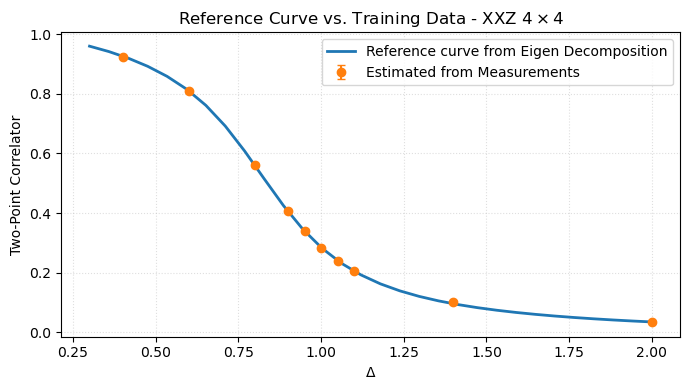

In [19]:
# CELL 3 — plot reference Czz(Δ) and data support points

fig, ax = plt.subplots(figsize=(7, 4))

# reference curve from ED (30 points)
ax.plot(ref_df["delta"], ref_df["czz_diag"],
        label=r"Reference curve from Eigen Decomposition",
        linewidth=2)

# support deltas from measurement dataset
ax.errorbar(
    data_deltas,
    data_czz,
    yerr=data_czz_err,
    fmt="o",
    capsize=3,
    label=r"Estimated from Measurements",
)

ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"Two-Point Correlator")
ax.set_title(r"Reference Curve vs. Training Data - XXZ $4 \times 4$")
ax.grid(True, linestyle=":", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()